In [1]:
%matplotlib inline
import numpy as np
np.set_printoptions(linewidth=np.inf)
np.set_printoptions(precision=7)
import matplotlib.pyplot as plt
import math 
import pandas as pd
from numpy import linalg as LA
from sympy import * 
import tqdm

In [2]:
# Scale function
def scale(vec_1):
    
    # Test
    v1_scale = np.square(np.linalg.norm(vec_1))
#     print(v1_scale)

    v1 = np.multiply(1/np.sqrt(v1_scale + 1e-15),vec_1)
#     print(v1)
    
    return list(v1)
    
    
def QR(span):
    
    # Setup arrays
    # Original Values
    vector = []
    # Normalized Values
    vec_norm = []

    # Size of array
    row,col = span.shape
    
    # First Column
    v1 = span[:,0]
    vec_1 = v1
    vector.append(vec_1)

    v1 = scale(vec_1)
    vec_norm.append(v1)
    
    # Subsequent Columns

    start = 1
    end = col

    for j in range(start,end):

        # Column
        projection = span[:,j]
        v = span[:,j]

        #Orthonormal vector
        for i in range(len(vec_norm)):
            #projection
            # dot
            proj_dot = np.dot(v,vec_norm[i])/(np.dot(vec_norm[i],vec_norm[i]) + 1e-15)
            proj = np.multiply(proj_dot,vec_norm[i])
            projection = projection - proj

        v_norm = scale(projection)

        vec_norm.append(v_norm)
        
    # Calculate R
    Q = vec_norm
    Q = np.array(Q)
    R = np.dot(Q,span)
    R = np.array(R)

    
    return Q.T,R

def eigenspace(span):
    
    eig_vec = np.eye(span.shape[0])
    X = span.copy()

    for _ in range(100):
        Q,R = QR(X)
        eig_vec = np.dot(eig_vec,Q)
        X = np.dot(R,Q)
        eig_val = np.diag(X)
        
    return eig_val,eig_vec, X


def CoV(df):
    
    # Shape of dataframe
    row,col = df.shape
    print(row,col)
    
    # Determine indices
#     if row > col:
#         row = col
#         col = row
    
    # Initialize Covariance matrix
    CoVar = np.zeros((col,col))
    
    # List of means
    stats = []
    for i in range(col):
        stats.append(df.iloc[:,i].mean())

    # Solve covariance matrix        
    for k in range(col):
        for i in range(col):
            var = 0
            for j in range(row):
                var = var + ((df.iloc[j,k] - stats[k])*(df.iloc[j,i] - stats[i]))/(row-1)
            CoVar[k][i] = var
        
    return CoVar
    
    

In [3]:
def cosine_similarity(v1, v2):
    return np.dot(v1, v2) / np.sqrt(np.dot(v1, v1) * np.dot(v2, v2))

In [4]:
def get_column(A, j):
    """Returns the j-th column of A (as a Vector)"""
    A = np.array(A)
    return [A_i[j]          # jth element of row A_i
            for A_i in A]   # for each row A_i

In [5]:
def gradient_step(v,gradient,step_size):
    step = np.multiply(step_size,gradient)
    return np.add(v,step)

In [6]:
def de_mean(data):
    mean = np.mean(data)
    return [np.subtract(vector,mean) for vector in data]

In [7]:
# def sum_of_squares(v):
#     """Returns v_1 * v_1 + ... + v_n * v_n"""
#     return np.dot(v, v)

# def magnitude(v):
#     """Returns the magnitude (or length) of v""" 
#     return np.sqrt(sum_of_squares(v))   # math.sqrt is square root function

def direction(w):
#     mag = np.sqrt(sum_of_squares(w))
    mag = np.linalg.norm(w)
#     mag = magnitude(w)
    return [w_i / mag for w_i in w]

In [8]:
def directional_variance(data, w):     
    """
    Returns the variance of x in the direction of w
    """
    w_dir = direction(w)
    return sum(np.dot(v, w_dir) ** 2 for v in data)

In [9]:
def directional_variance_gradient(data, w):
    """
    The gradient of directional variance with respect to w
    """
    w_dir = direction(w)

    return [sum(2 * np.dot(v, w_dir) * v[i] for v in data)
            for i in range(len(w))]

In [10]:
def first_principal_component(data, n=100, step_size=0.1):
    # Start with a random guess
    guess = [1.0 for _ in data[0]]
    with tqdm.trange(n) as t:
        for _ in t:
            dv = directional_variance(data, guess)
            gradient = directional_variance_gradient(data, guess)
            guess = gradient_step(guess, gradient, step_size)
            t.set_description(f"dv: {dv:.3f}")
    return direction(guess)
    

In [11]:
def project(v,w):
    projection_length = np.dot(v,w)
    return np.multiply(projection_length, w)

def remove_projection_from_vector(v,w):
    return np.subtract(v,project(v,w))

def remove_projection(data,w):
    return [remove_projection_from_vector(v,w) for v in data]

In [12]:
def pca(data,num_components):
    components = []
    for _ in range(num_components):
        component = first_principal_component(data)
        components.append(component)
        data = remove_projection(data,component)
    return components

In [13]:
def transform_vector(v,components):
    return [np.dot(v,w) for w in components]

def transform(data, components):
    return [transform_vector(v, components) for v in data]

In [14]:
def principal_components(X, num_components, n, step):
    components = []
    for _ in range(num_components):
        component = first_principal_component(X,n,step)
        components.append(component)
        X = remove_projection(X, component)
    return components

In [15]:
# Create panda matrix
x = [2.5,0.5,2.2,1.9,3.1,2.3,2,1,1.5,1.1]
x = np.array(x)
x = de_mean(x.T)
print(x)
y = [2.4,0.7,2.9,2.2,3.0,2.7,1.6,1.1,1.6,0.9]
y = np.array(y)
y = de_mean(y.T)
print(y)
x = np.array(x)
y = np.array(y)
C = np.vstack((x,y))
# C = C.reshape(len(x),2)
print(C)
B = C.T
print(B)

# D = de_mean(C)
# D = np.array(D)
# print(D.T)

# n = 100
# A = [[x,y] for x,y in zip(np.random.randn(n) * 10, np.random.randn(n) * 3)]

# theta = - math.pi / 7
# rotate = [[math.cos(theta), -math.sin(theta)],
#           [math.sin(theta), math.cos(theta)]]

# A = np.array(A)
# print(A)
# B = np.dot(A, rotate)


print(B)

# comp = pca(x,2)

[0.69, -1.31, 0.3900000000000001, 0.08999999999999986, 1.29, 0.48999999999999977, 0.18999999999999995, -0.81, -0.31000000000000005, -0.71]
[0.48999999999999977, -1.2100000000000002, 0.9899999999999998, 0.29000000000000004, 1.0899999999999999, 0.79, -0.31000000000000005, -0.81, -0.31000000000000005, -1.0100000000000002]
[[ 0.69 -1.31  0.39  0.09  1.29  0.49  0.19 -0.81 -0.31 -0.71]
 [ 0.49 -1.21  0.99  0.29  1.09  0.79 -0.31 -0.81 -0.31 -1.01]]
[[ 0.69  0.49]
 [-1.31 -1.21]
 [ 0.39  0.99]
 [ 0.09  0.29]
 [ 1.29  1.09]
 [ 0.49  0.79]
 [ 0.19 -0.31]
 [-0.81 -0.81]
 [-0.31 -0.31]
 [-0.71 -1.01]]
[[ 0.69  0.49]
 [-1.31 -1.21]
 [ 0.39  0.99]
 [ 0.09  0.29]
 [ 1.29  1.09]
 [ 0.49  0.79]
 [ 0.19 -0.31]
 [-0.81 -0.81]
 [-0.31 -0.31]
 [-0.71 -1.01]]


In [16]:
row_data_adjust = pd.DataFrame(B)
row_data_adjust = row_data_adjust
row_data_adjust.columns = ['x','y']

print(row_data_adjust)

# Maximum value
max_val_1 = max(abs(row_data_adjust).max(axis = 0))
print(max_val_1)

      x     y
0  0.69  0.49
1 -1.31 -1.21
2  0.39  0.99
3  0.09  0.29
4  1.29  1.09
5  0.49  0.79
6  0.19 -0.31
7 -0.81 -0.81
8 -0.31 -0.31
9 -0.71 -1.01
1.31


In [17]:
CoVar = CoV(row_data_adjust)
print(CoVar)

10 2
[[0.6165556 0.6154444]
 [0.6154444 0.7165556]]


In [18]:
eig_val,eig_vec,X = eigenspace(CoVar)
print(eig_val)
print(eig_vec)

[1.2840277 0.0490834]
[[ 0.6778734 -0.7351787]
 [ 0.7351787  0.6778734]]


In [19]:
print(eig_val[0])
eigenvalue_3sigma = 3 * np.sqrt(eig_val[0]) 
eigenvalue_3sigma_arr = np.array([[-eigenvalue_3sigma, eigenvalue_3sigma]])
eigenvector = np.array([eig_vec[0]]).T *1
print(eigenvector)
print(eigenvalue_3sigma_arr)
# x_comp_1,y_comp_1 = np.multiply(np.dot(-eigenvector, -eigenvalue_3sigma_arr), -1)
# print(x_comp_1)
# print(y_comp_1)
x_comp_1 = eigenvector[0].dot(eigenvalue_3sigma_arr)
y_comp_1 = -eigenvector[1].dot(eigenvalue_3sigma_arr)
print(x_comp_1)
print(y_comp_1)

1.2840277121726855
[[ 0.6778734]
 [-0.7351787]]
[[-3.3994484  3.3994484]]
[-2.3043956  2.3043956]
[-2.4992019  2.4992019]


In [20]:
print(eig_val[1])
eigenvalue_3sigma = 3 * np.sqrt(eig_val[1]) 
eigenvalue_3sigma_arr = np.array([[-eigenvalue_3sigma, eigenvalue_3sigma]])
eigenvector = np.array([eig_vec[1]]).T * 1
# x_comp_2,y_comp_2 = np.multiply(np.dot(-eigenvector, -eigenvalue_3sigma_arr), -1)
x_comp_2 = eigenvector[0].dot(eigenvalue_3sigma_arr)
y_comp_2 = -eigenvector[1].dot(eigenvalue_3sigma_arr)
# print(x_comp_1)
# print(y_comp_1)
print(x_comp_2)
print(y_comp_2)

0.04908339893630035
[-0.4886315  0.4886315]
[ 0.4505439 -0.4505439]


0    0.69
1   -1.31
2    0.39
3    0.09
4    1.29
5    0.49
6    0.19
7   -0.81
8   -0.31
9   -0.71
Name: x, dtype: float64
[ 0.69 -1.31  0.39  0.09  1.29  0.49  0.19 -0.81 -0.31 -0.71]


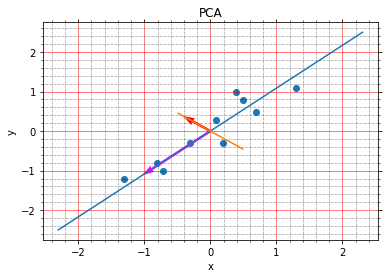

In [21]:
print(row_data_adjust['x'])
print(np.array(row_data_adjust['x']))

plt.scatter(np.array(row_data_adjust['x']), np.array(row_data_adjust['y']))
plt.plot(x_comp_1,y_comp_1)
plt.plot(x_comp_2,y_comp_2)
plt.quiver(x_comp_2[0],y_comp_2[0], scale = 7, angles='xy', color='red')
plt.quiver(x_comp_1[0],y_comp_1[0], scale = 14, angles='xy', color='magenta')

# naming the x axis
plt.xlabel('x')
# naming the y axis
plt.ylabel('y')
# giving a title  
plt.title('PCA') 
# Turn on the minor TICKS, which are required for the minor GRID
plt.minorticks_on()

# Customize the major grid
plt.grid(which='major', linestyle='-', linewidth='0.5', color='red')
# Customize the minor grid
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')

# Turn off the display of all ticks.
plt.tick_params(which='both', # Options for both major and minor ticks
                top='off', # turn off top ticks
                left='off', # turn off left ticks
                right='off',  # turn off right ticks
                bottom='off') # turn off bottom ticks

plt.show()

In [22]:
comp = pca(B,2)
print(comp)

# np.dot(comp[0],comp[1])

dv: 0.405: 100%|███████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1389.62it/s]

[[0.6781015995715335, 0.7349681766297965], [0.8966375873912281, -0.44276521642653666]]


In [23]:
transform = transform(B,comp)
transform = np.array(transform)
transform = transform.T
print(transform)

[[ 0.8280245 -1.7776246  0.9920781  0.2741699  1.6758664  0.9128946 -0.0990008 -1.1445865 -0.4380516 -1.22377  ]
 [ 0.401725  -0.6388493 -0.0886489 -0.0477045  0.6740484  0.0895679  0.3076184 -0.3676366 -0.1407004 -0.1894198]]


In [24]:
# plt.scatter(transform[0],transform[1])
# D = np.array(D).T
# plt.scatter(D[0],D[1])

In [25]:
# eig_val,eig_vec = np.linalg.eig(comp)
# print(eig_val)
# print(eig_vec)

# print(eig_val[0])
# eigenvalue_3sigma = 3 * np.sqrt(eig_val[0]) 
# eigenvalue_3sigma_arr = np.array([[-eigenvalue_3sigma, eigenvalue_3sigma]])
# eigenvector = np.array([eig_vec[0]]).T *1
# print(eigenvector)
# print(eigenvalue_3sigma_arr)
# # x_comp_1,y_comp_1 = np.multiply(np.dot(-eigenvector, -eigenvalue_3sigma_arr), -1)
# # print(x_comp_1)
# # print(y_comp_1)
# x_comp_1 = eigenvector[0].dot(eigenvalue_3sigma_arr)
# y_comp_1 = -eigenvector[1].dot(eigenvalue_3sigma_arr)
# print(x_comp_1)
# print(y_comp_1)

In [26]:
# pc1 = first_principal_component(B)
# print(pc1)

pcs = principal_components(B, 2, 100, 0.1)
print(pcs)

pcs = np.array(pcs)
pcs /= pcs.std()
print(pcs)

dv: 0.405: 100%|███████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1517.35it/s]

[[0.6781015995715335, 0.7349681766297965], [0.8966375873912281, -0.44276521642653666]]
[[ 1.2765818  1.3836377]
 [ 1.6879936 -0.8335418]]


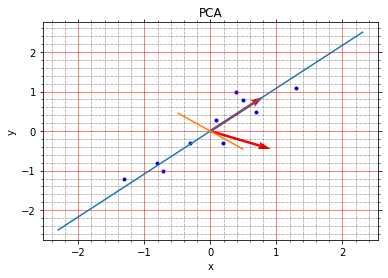

In [27]:
# B = B.T
# plt.scatter(B[0],B[1])
# # plt.scatter(, get_column(B,1), marker='.', color='blue')
# x = [pc1[0]*i for i in [-30, 1, 30]]
# y = [pc1[1]*i for i in [-30, 1, 30]]
# plt.plot(x, y, color="#cc000030", linewidth=2)
# plt.quiver(0,0,get_column(pcs[0][0], 0), get_column(pcs[0][0], 1), angles='xy', scale=4, color='red')
# # plt.quiver(0,0,pc1[0], pc1[1], angles='xy', scale=4, color='red')
# # plt.quiver(0,0,pc1[0], pc1[1], angles='xy', scale=4, color='red')

# print(B)

# B = np.array(row_data_adjust)
# print(B)

plt.scatter(get_column(B,0), get_column(B,1), marker='.', color='blue')
plt.plot(x_comp_1,y_comp_1)
plt.plot(x_comp_2,y_comp_2)
plt.quiver(pcs[0][0], pcs[0][1], angles='xy', scale=10, color='red')
plt.quiver(pcs[1][0], pcs[1][1], angles='xy', scale=10, color='red')


# plt.scatter(get_column(B,0), get_column(B,1), marker='.', color='blue')
# plt.quiver(get_column(pcs, 0), get_column(pcs, 1), angles='xy',scale = 10, color='red')

# naming the x axis
plt.xlabel('x')
# naming the y axis
plt.ylabel('y')
# giving a title  
plt.title('PCA') 
# Turn on the minor TICKS, which are required for the minor GRID
plt.minorticks_on()

# Customize the major grid
plt.grid(which='major', linestyle='-', linewidth='0.5', color='red')
# Customize the minor grid
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')

# Turn off the display of all ticks.
plt.tick_params(which='both', # Options for both major and minor ticks
                top='off', # turn off top ticks
                left='off', # turn off left ticks
                right='off',  # turn off right ticks
                bottom='off') # turn off bottom ticks


plt.show()

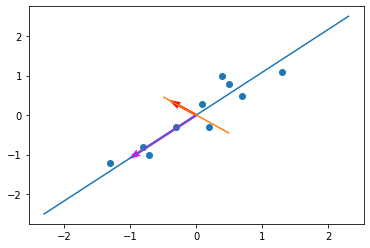

In [28]:
plt.scatter(np.array(row_data_adjust['x']), np.array(row_data_adjust['y']))
plt.plot(x_comp_1,y_comp_1)
plt.plot(x_comp_2,y_comp_2)
plt.quiver(x_comp_2[0],y_comp_2[0], scale = 7, angles='xy', color='red')
plt.quiver(x_comp_1[0],y_comp_1[0], scale = 14, angles='xy', color='magenta')


plt.show()

In [29]:
# plt.scatter(get_column(B,0), get_column(B,1), marker='.', color='blue')
# plt.quiver(0,0,get_column(pcs, 0), get_column(pcs, 1), angles='xy', scale=4, color='red')
# plt.show()

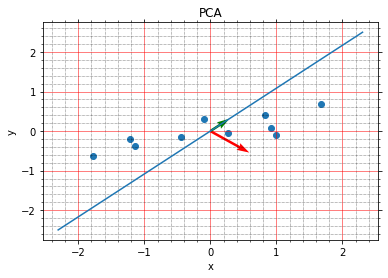

In [30]:
# plt.scatter(FinalData_1,FinalData_1)
# plt.scatter(FinalData[0],FinalData[1])
plt.scatter(transform[0],transform[1])
plt.plot(x_comp_1,y_comp_1)
# plt.plot(x_comp_2,y_comp_2, color='magenta')
plt.quiver(x_comp_2[1],y_comp_2[1], scale = 5, angles='xy', color='red')
plt.quiver(x_comp_1[1],y_comp_1[1], scale = 50, angles='xy', color='Green')

# naming the x axis
plt.xlabel('x')
# naming the y axis
plt.ylabel('y')
# giving a title  
plt.title('PCA') 
# Turn on the minor TICKS, which are required for the minor GRID
plt.minorticks_on()

# Customize the major grid
plt.grid(which='major', linestyle='-', linewidth='0.5', color='red')
# Customize the minor grid
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')

# Turn off the display of all ticks.
plt.tick_params(which='both', # Options for both major and minor ticks
                top='off', # turn off top ticks
                left='off', # turn off left ticks
                right='off',  # turn off right ticks
                bottom='off') # turn off bottom ticks

plt.show()

In [31]:
transform = pd.DataFrame(transform.T)
transform = transform
transform.columns = ['x','y']

# maximum value
max_val_2 = max(transform.max(axis = 0))

print(row_data_adjust)
# print(abs(transform['x']).max())
# print(abs(transform['y']).max())
# max(transform.max(axis = 0))

      x     y
0  0.69  0.49
1 -1.31 -1.21
2  0.39  0.99
3  0.09  0.29
4  1.29  1.09
5  0.49  0.79
6  0.19 -0.31
7 -0.81 -0.81
8 -0.31 -0.31
9 -0.71 -1.01


In [32]:
CoVar = CoV(transform)
print(CoVar)

10 2
[[1.2840276 0.3624895]
 [0.3624895 0.1474968]]


In [33]:
eig_val,eig_vec,X = eigenspace(CoVar)
print(eig_val)
print(eig_vec)

[1.389798  0.0417265]
[[ 0.9599685 -0.280108 ]
 [ 0.280108   0.9599685]]


In [34]:
print(eig_val[0])
eigenvalue_3sigma = 3  * np.sqrt(eig_val[0]) 
eigenvalue_3sigma_arr = np.array([[-eigenvalue_3sigma, eigenvalue_3sigma]])
eigenvector = np.array([eig_vec[0]]).T *1
print(eigenvector)
print(eigenvalue_3sigma_arr)
# x_comp_1,y_comp_1 = np.multiply(np.dot(-eigenvector, -eigenvalue_3sigma_arr), -1)
# print(x_comp_1)
# print(y_comp_1)
x_comp_transform_1 = eigenvector[0].dot(eigenvalue_3sigma_arr)
y_comp_transform_1 = -eigenvector[1].dot(eigenvalue_3sigma_arr)
print(x_comp_1)
print(y_comp_1)

1.3897979559775289
[[ 0.9599685]
 [-0.280108 ]]
[[-3.5366908  3.5366908]]
[-2.3043956  2.3043956]
[-2.4992019  2.4992019]


In [35]:
print(eig_val[1])
eigenvalue_3sigma = 3  * np.sqrt(eig_val[1]) 
eigenvalue_3sigma_arr = np.array([[-eigenvalue_3sigma, eigenvalue_3sigma]])
eigenvector = np.array([eig_vec[1]]).T * 1
# x_comp_2,y_comp_2 = np.multiply(np.dot(-eigenvector, -eigenvalue_3sigma_arr), -1)
x_comp_transform_2 = eigenvector[0].dot(eigenvalue_3sigma_arr)
y_comp_transform_2 = -eigenvector[1].dot(eigenvalue_3sigma_arr)
# print(x_comp_1)
# print(y_comp_1)
print(x_comp_2)
print(y_comp_2)

0.04172648699616342
[-0.4886315  0.4886315]
[ 0.4505439 -0.4505439]


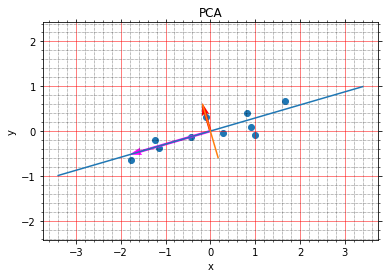

In [36]:
plt.scatter(transform['x'],transform['y'])
plt.plot(x_comp_transform_1,y_comp_transform_1)
plt.plot(x_comp_transform_2,y_comp_transform_2)
plt.quiver(x_comp_transform_2[0],y_comp_transform_2[0], scale = 7, angles='xy', color='red')
plt.quiver(x_comp_transform_1[0],y_comp_transform_1[0], scale = 14, angles='xy', color='magenta')

# naming the x axis
plt.xlabel('x')
# naming the y axis
plt.ylabel('y')
# giving a title  
plt.title('PCA') 
# Axis
# plt.xlim([-2,2])
# plt.ylim([-2,2])
plt.axis('equal')
# Turn on the minor TICKS, which are required for the minor GRID
plt.minorticks_on()

# Customize the major grid
plt.grid(which='major', linestyle='-', linewidth='0.5', color='red')
# Customize the minor grid
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')

# Turn off the display of all ticks.
plt.tick_params(which='both', # Options for both major and minor ticks
                top='off', # turn off top ticks
                left='off', # turn off left ticks
                right='off',  # turn off right ticks
                bottom='off') # turn off bottom ticks

plt.show()

In [37]:
cos_sim = cosine_similarity(x_comp_1[0],y_comp_1[0])
print(cos_sim)

1.0


0    0.69
1   -1.31
2    0.39
3    0.09
4    1.29
5    0.49
6    0.19
7   -0.81
8   -0.31
9   -0.71
Name: x, dtype: float64
[ 0.69 -1.31  0.39  0.09  1.29  0.49  0.19 -0.81 -0.31 -0.71]


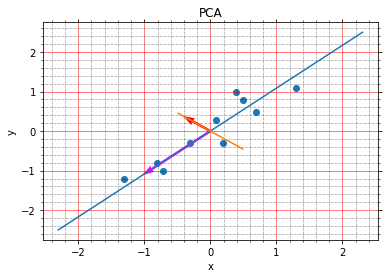

In [38]:
print(row_data_adjust['x'])
print(np.array(row_data_adjust['x']))

plt.scatter(row_data_adjust['x'], row_data_adjust['y'])
plt.plot(x_comp_1,y_comp_1)
plt.plot(x_comp_2,y_comp_2)
plt.quiver(x_comp_2[0],y_comp_2[0], scale = 7, angles='xy', color='red')
plt.quiver(x_comp_1[0],y_comp_1[0], scale = 14, angles='xy', color='magenta')

# naming the x axis
plt.xlabel('x')
# naming the y axis
plt.ylabel('y')
# giving a title  
plt.title('PCA') 
# Turn on the minor TICKS, which are required for the minor GRID
plt.minorticks_on()

# Customize the major grid
plt.grid(which='major', linestyle='-', linewidth='0.5', color='red')
# Customize the minor grid
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')

# Turn off the display of all ticks.
plt.tick_params(which='both', # Options for both major and minor ticks
                top='off', # turn off top ticks
                left='off', # turn off left ticks
                right='off',  # turn off right ticks
                bottom='off') # turn off bottom ticks

plt.show()